In [1]:
import warnings

import pooch

# don't need to show warning about setting up optimizer
warnings.filterwarnings(
    "ignore",
    message="You will need to call setup",
    category=UserWarning,
)

# don't have pooch output messages about downloading or untarring
logger = pooch.get_logger()
logger.setLevel("WARNING")

:::{admonition} Download
:class: important

Download this notebook: **{nb-download}`ps_extensions.ipynb`**!

:::

(ps-extensions)=
# More than just texture metamers

This notebook shows several uses of the Portilla-Simoncelli model metamer synthesis beyond just creating more textures: extrapolating an image and creating mixtures of two textures.

:::{admonition} Reproducing the metamers in this notebook
:class: warning dropdown

Due to pytorch's limitations, we [cannot guarantee perfect reproducibility](reproduce).
However, we've found the setup shown in this notebook works reliably across different images and produce good metamers efficiently.

If you use follow these basic steps and **are not** able to successfully synthesize a good `PortillaSimoncelli` <!-- skip-lint --> model metamer, please post on our [discussion board](https://github.com/plenoptic-org/plenoptic/discussions/) and we'll try to help!

See [](ps-optimization) for more information about the specific decisions taken around optimization, including what "good" means.

:::

In [2]:
import matplotlib.pyplot as plt
import torch

import plenoptic as po

%load_ext autoreload
%autoreload 2

# We need to download some additional images for this notebook.
IMG_PATH = po.data.fetch_data("portilla_simoncelli_images.tar.gz")
CACHE_DIR = po.data.fetch_data("ps_regression.tar.gz")
# use GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72

# set seed for reproducibility
po.tools.set_seed(1)

:::{admonition} This notebook retrieves cached synthesis results
:class: warning dropdown
This notebook contains many metamers and, while any one synthesis operation does not take too long, all of them combined result in a lengthy notebook. Therefore, instead of performing synthesis in this notebook, we have cached the result of most of these syntheses online and only download them for investigation.

Additionally, while you can normally call {func}`~plenoptic.synthesize.metamer.Metamer.synthesize` again to pick up where we left out, the cached version of the results shown here discarded the optimizer's state dict (to reduce the size on disk). Thus, calling `met.synthesize(100)` with one of our cached and loaded metamer objects **will not** give the same result as calling `met.synthesize(200)` with a new metamer object initialized as shown in this notebook.

:::

## Extrapolation

(See figure 19 of {cite:alp}`Portilla2000-param-textur`.)

Here we explore using the texture synthesis model for extrapolating beyond its spatial boundaries.

Excerpt from paper: _"...\[C\]onsider the problem of extending a texture image beyond its spatial boundaries (spatial extrapolation). We want to synthesize an image in which the central pixels contain a copy of the original image, and the surrounding pixels are synthesized based on the statistical measurements of the original image. The set of all images with the same central subset of pixels is convex, and the projection onto such a convex set is easily inserted into the iterative loop of the synthesis algorithm. Specifically, we need only re-set the central pixels to the desired values on each iteration of the synthesis loop. In practice, this substitution is done by multiplying the desired pixels by a smooth mask (a raised cosine) and adding this to the current synthesized image multiplied by the complement of this mask. The smooth mask prevents artifacts at the boundary between original and synthesized pixels, whereas convergence to the desired pixels within the mask support region is achieved almost perfectly. This technique is applicable to the restoration of pictures which have been destroyed in some subregion (“filling holes”) (e.g., Hirani and Totsuka, 1996), although the estimation of parameters from the defective image is not straightforward. Figure 19 shows a set of examples that have been spatially extrapolated using this method. Observe that the border between real and synthetic data is barely noticeable. An additional potential benefit is that the synthetic images are seamlessly periodic (due to circular boundary-handling within our algorithm), and thus may be used to tile a larger
image."_

In the following, we mask out the boundaries of an image and use the texture model to extend it. If you are interested in the details, you can expand the following block to see how we do so.

In [3]:
# The following class inherits from the PortillaSimoncelli model for
# the purpose of extrapolating (filling in) a chunk of an imaged defined
# by a mask.


class PortillaSimoncelliMask(po.simul.PortillaSimoncelli):
    r"""Extend the PortillaSimoncelli model to operate on masked images.

    Additional Parameters
    ----------
    mask: Tensor
        boolean mask with True in the part of the image that will be filled in during
        synthesis
    target: Tensor
        image target for synthesis

    """

    def __init__(
        self,
        im_shape,
        n_scales=4,
        n_orientations=4,
        spatial_corr_width=9,
        mask=None,
        target=None,
    ):
        super().__init__(im_shape, n_scales=4, n_orientations=4, spatial_corr_width=9)
        self.mask = mask
        self.target = target

    def forward(self, image, scales=None):
        r"""Generate Texture Statistics representation of an image using the target for
        the masked portion

        Parameters
        ----------
        images : torch.Tensor
            A 4d tensor containing two images to analyze, with shape (2,
            channel, height, width).
        scales : list, optional
            Which scales to include in the returned representation. If an empty
            list (the default), we include all scales. Otherwise, can contain
            subset of values present in this model's scales attribute.

        Returns
        -------
        representation_tensor: torch.Tensor
            3d tensor of shape (batch, channel, stats) containing the measured
            texture statistics.

        """
        if self.mask is not None and self.target is not None:
            image = self.texture_masked_image(image)

        return super().forward(image, scales=scales)

    def texture_masked_image(self, image):
        r"""Fill in part of the image (designated by the mask) with the saved target
        image

        Parameters
        ------------
        image : torch.Tensor
            A tensor containing a single image

        Returns
        -------
        texture_masked_image: torch.Tensor
            An image that is a combination of the input image and the saved target.
            Combination is specified by self.mask

        """
        return self.target * self.mask + image * (~self.mask)

In [4]:
img_file = IMG_PATH / "fig14b.jpg"
img = po.tools.load_images(img_file).to(DEVICE).to(torch.float64)
mask = torch.zeros_like(img).bool()
ctr_dim = (img.shape[-2] // 4, img.shape[-1] // 4)
mask[..., ctr_dim[0] : 3 * ctr_dim[0], ctr_dim[1] : 3 * ctr_dim[1]] = True

model = PortillaSimoncelliMask(img.shape[-2:], target=img, mask=mask).to(DEVICE)
loss = po.tools.optim.portilla_simoncelli_loss_factory(model, img)
met = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met.load(CACHE_DIR / "ps_mask.pt", map_location=DEVICE)

:::{admonition} How to run this synthesis manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_mask -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
met.synthesize(max_iter=100)
```
:::

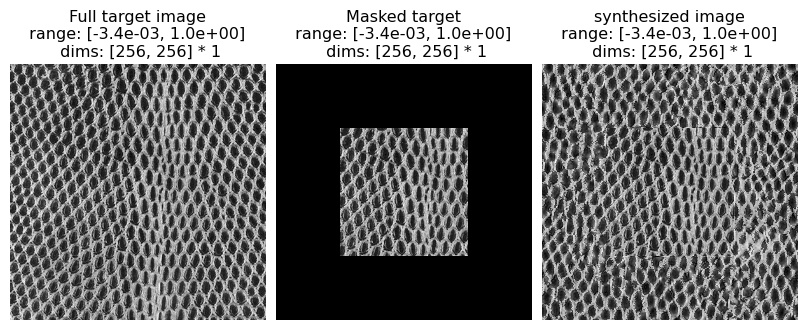

In [5]:
po.imshow(
    [met.image, mask * met.image, model.texture_masked_image(met.metamer)],
    vrange="auto1",
    title=["Full target image", "Masked target", "synthesized image"],
);

## Texture Mixtures

(See figure 20 of {cite:alp}`Portilla2000-param-textur`.)

:::{versionchanged} 1.4
   In previous versions of this notebook, we averaged together the Portilla-Simoncelli representation of two images to create a "mixture". Now, we do as was done in the paper.
:::

Here we explore creating a texture that is "in between" two textures. We compute the target for these mixtures by calculating the statistics on a single input image that consisted of half of each of two texture images pasted together. This leads to an "oil and water" appearance in the resulting texture metamer, which appeared to have patches from each image. Note that, in all the other examples shown in these notebooks, we knew there exists *at least one* natural texture image whose output matches our optimization target: the image we started with. For these mixtures, that is no longer the case.

In [6]:
# Figure 20. Examples of “mixture” textures.
# To replicate paper use the following combinations:
# (Fig. 15a, Fig. 15b); (Fig. 14b, Fig. 4a); (Fig. 15e, Fig. 14e).

fig_names = ["fig15e", "fig14e"]
img_files = [IMG_PATH / f"{f}.jpg" for f in fig_names]
img = po.tools.load_images(img_files).to(DEVICE).to(torch.float64)
img = torch.cat([img[:1, ..., 128:], img[1:, ..., :128]], -1)

model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
loss = po.tools.optim.portilla_simoncelli_loss_factory(model, img)
met = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met.load(CACHE_DIR / f"ps_mixture_{'-'.join(fig_names)}.pt", map_location=DEVICE)

:::{admonition} How to run this synthesis manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_mixture -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
met.synthesize(max_iter=100)
```
:::

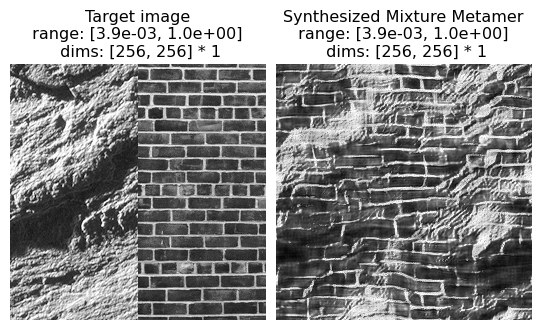

In [7]:
po.imshow(
    [met.image, met.metamer],
    vrange="auto1",
    title=["Target image", "Synthesized Mixture Metamer"],
);